In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics

df = pd.read_csv('data/fake_data.csv')

In [2]:
X = df[['AreaSQM', 'Number of Floors', 'Bedrooms', 'Carport', 'Yard']]
y = df[['PHP(1.00)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [3]:
# Create models
linear_regression = LinearRegression()
random_forest = RandomForestRegressor()

# Train the models using the training sets
linear_regression.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

# Make predictions using the testing set
linear_regression_predict = linear_regression.predict(X_test)
random_forest_predict = random_forest.predict(X_test)

C:\Users\evpit\Source\Repo\datascience-ai\venv\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [4]:
# R squared score for each prediction
print('Linear Regression R^2: %.2f' % metrics.r2_score(y_test, linear_regression_predict))
print('Random Forest R^2: %.2f' % metrics.r2_score(y_test, random_forest_predict))

Linear Regression R^2: 0.01
Random Forest R^2: -0.19


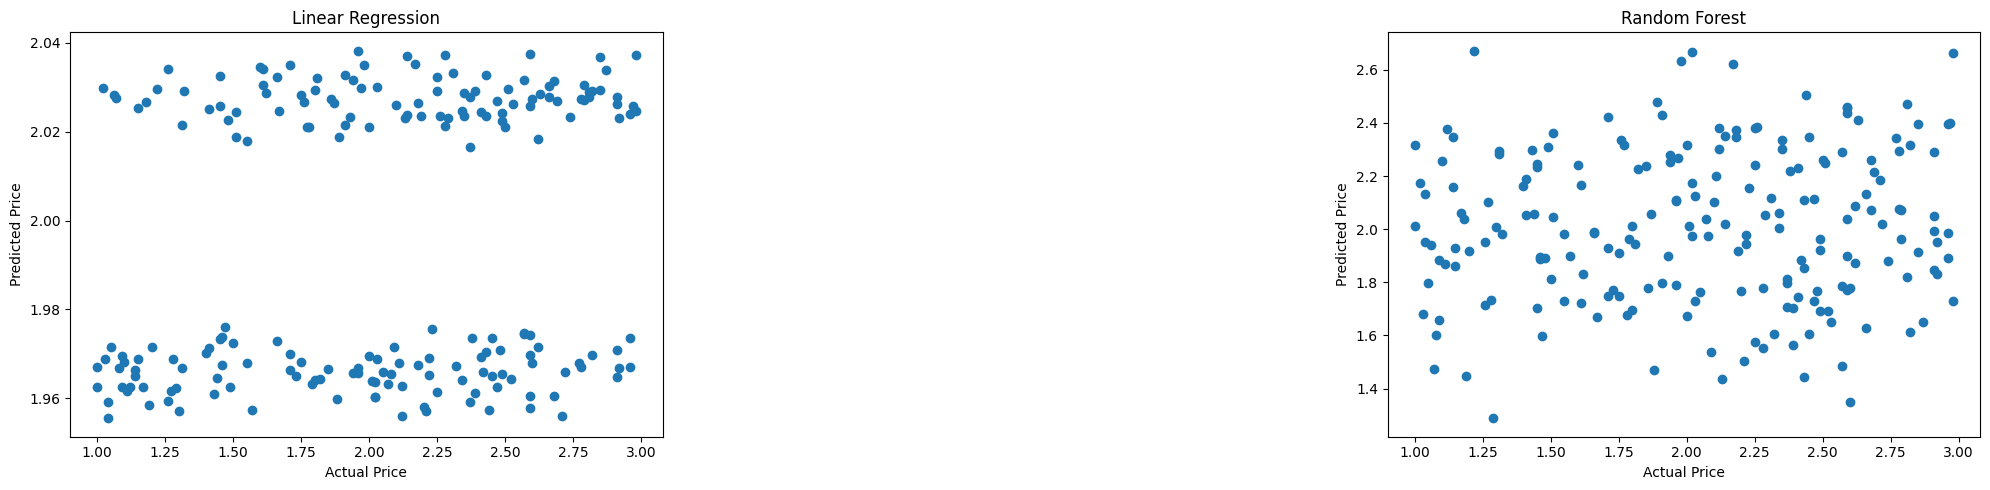

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, linear_regression_predict)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression')

plt.subplot(1, 3, 3)
plt.scatter(y_test, random_forest_predict)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest')

plt.tight_layout()
plt.show()